<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-23 23:16:14--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-23 23:16:14 (13.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



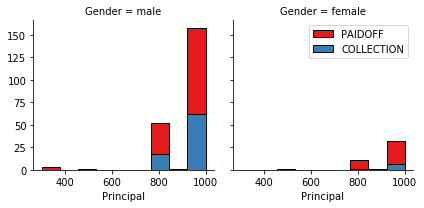

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

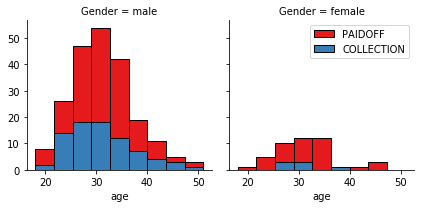

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

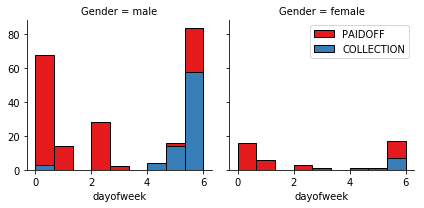

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [21]:
# convert default values to integer
df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [24]:
# create y values
y = df['loan_status'].values

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [27]:
# Show y values
print(y[0:30])
values, number_of_values = (np.unique(y, return_counts=True))
print(values)
print(number_of_values)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1]
[ 86 260]


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [28]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [29]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Let's split the data into train and test sets, we will use this for all 4 algorithms.  Using 20% for test set

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


Let's iterate through K = 1, 10 and find the best k.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 11
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857])

Let's visualize the accuracy

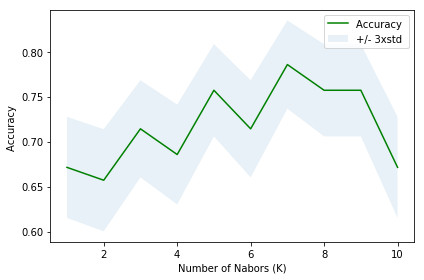

In [33]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

7 provided the most accurate model so we will run it one more time and use K = 7.

In [62]:
k = 7
final_neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

# Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [59]:
# test different max_depths for accuracy
for i in range(8):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = i+1)
    Tree.fit(X_train, y_train)
    predTree = Tree.predict(X_test)
    print(f'DecisionTrees\'s Accuracy with max_depth = {i+1}: {metrics.accuracy_score(y_test, predTree)}')

DecisionTrees's Accuracy with max_depth = 1: 0.7857142857142857
DecisionTrees's Accuracy with max_depth = 2: 0.7857142857142857
DecisionTrees's Accuracy with max_depth = 3: 0.6142857142857143
DecisionTrees's Accuracy with max_depth = 4: 0.6142857142857143
DecisionTrees's Accuracy with max_depth = 5: 0.6428571428571429
DecisionTrees's Accuracy with max_depth = 6: 0.7714285714285715
DecisionTrees's Accuracy with max_depth = 7: 0.7571428571428571
DecisionTrees's Accuracy with max_depth = 8: 0.7571428571428571


Interestingly, a max_depth of 1 or 2 actually provides the most accurate model, lets investigate further by seeing what the split criteria is, we may need to evaluate the other algorithms.

In [43]:
# you may need to run the below to install the packages needed to view the decision tree.
# !conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



DecisionTrees's Accuracy:  0.7714285714285715


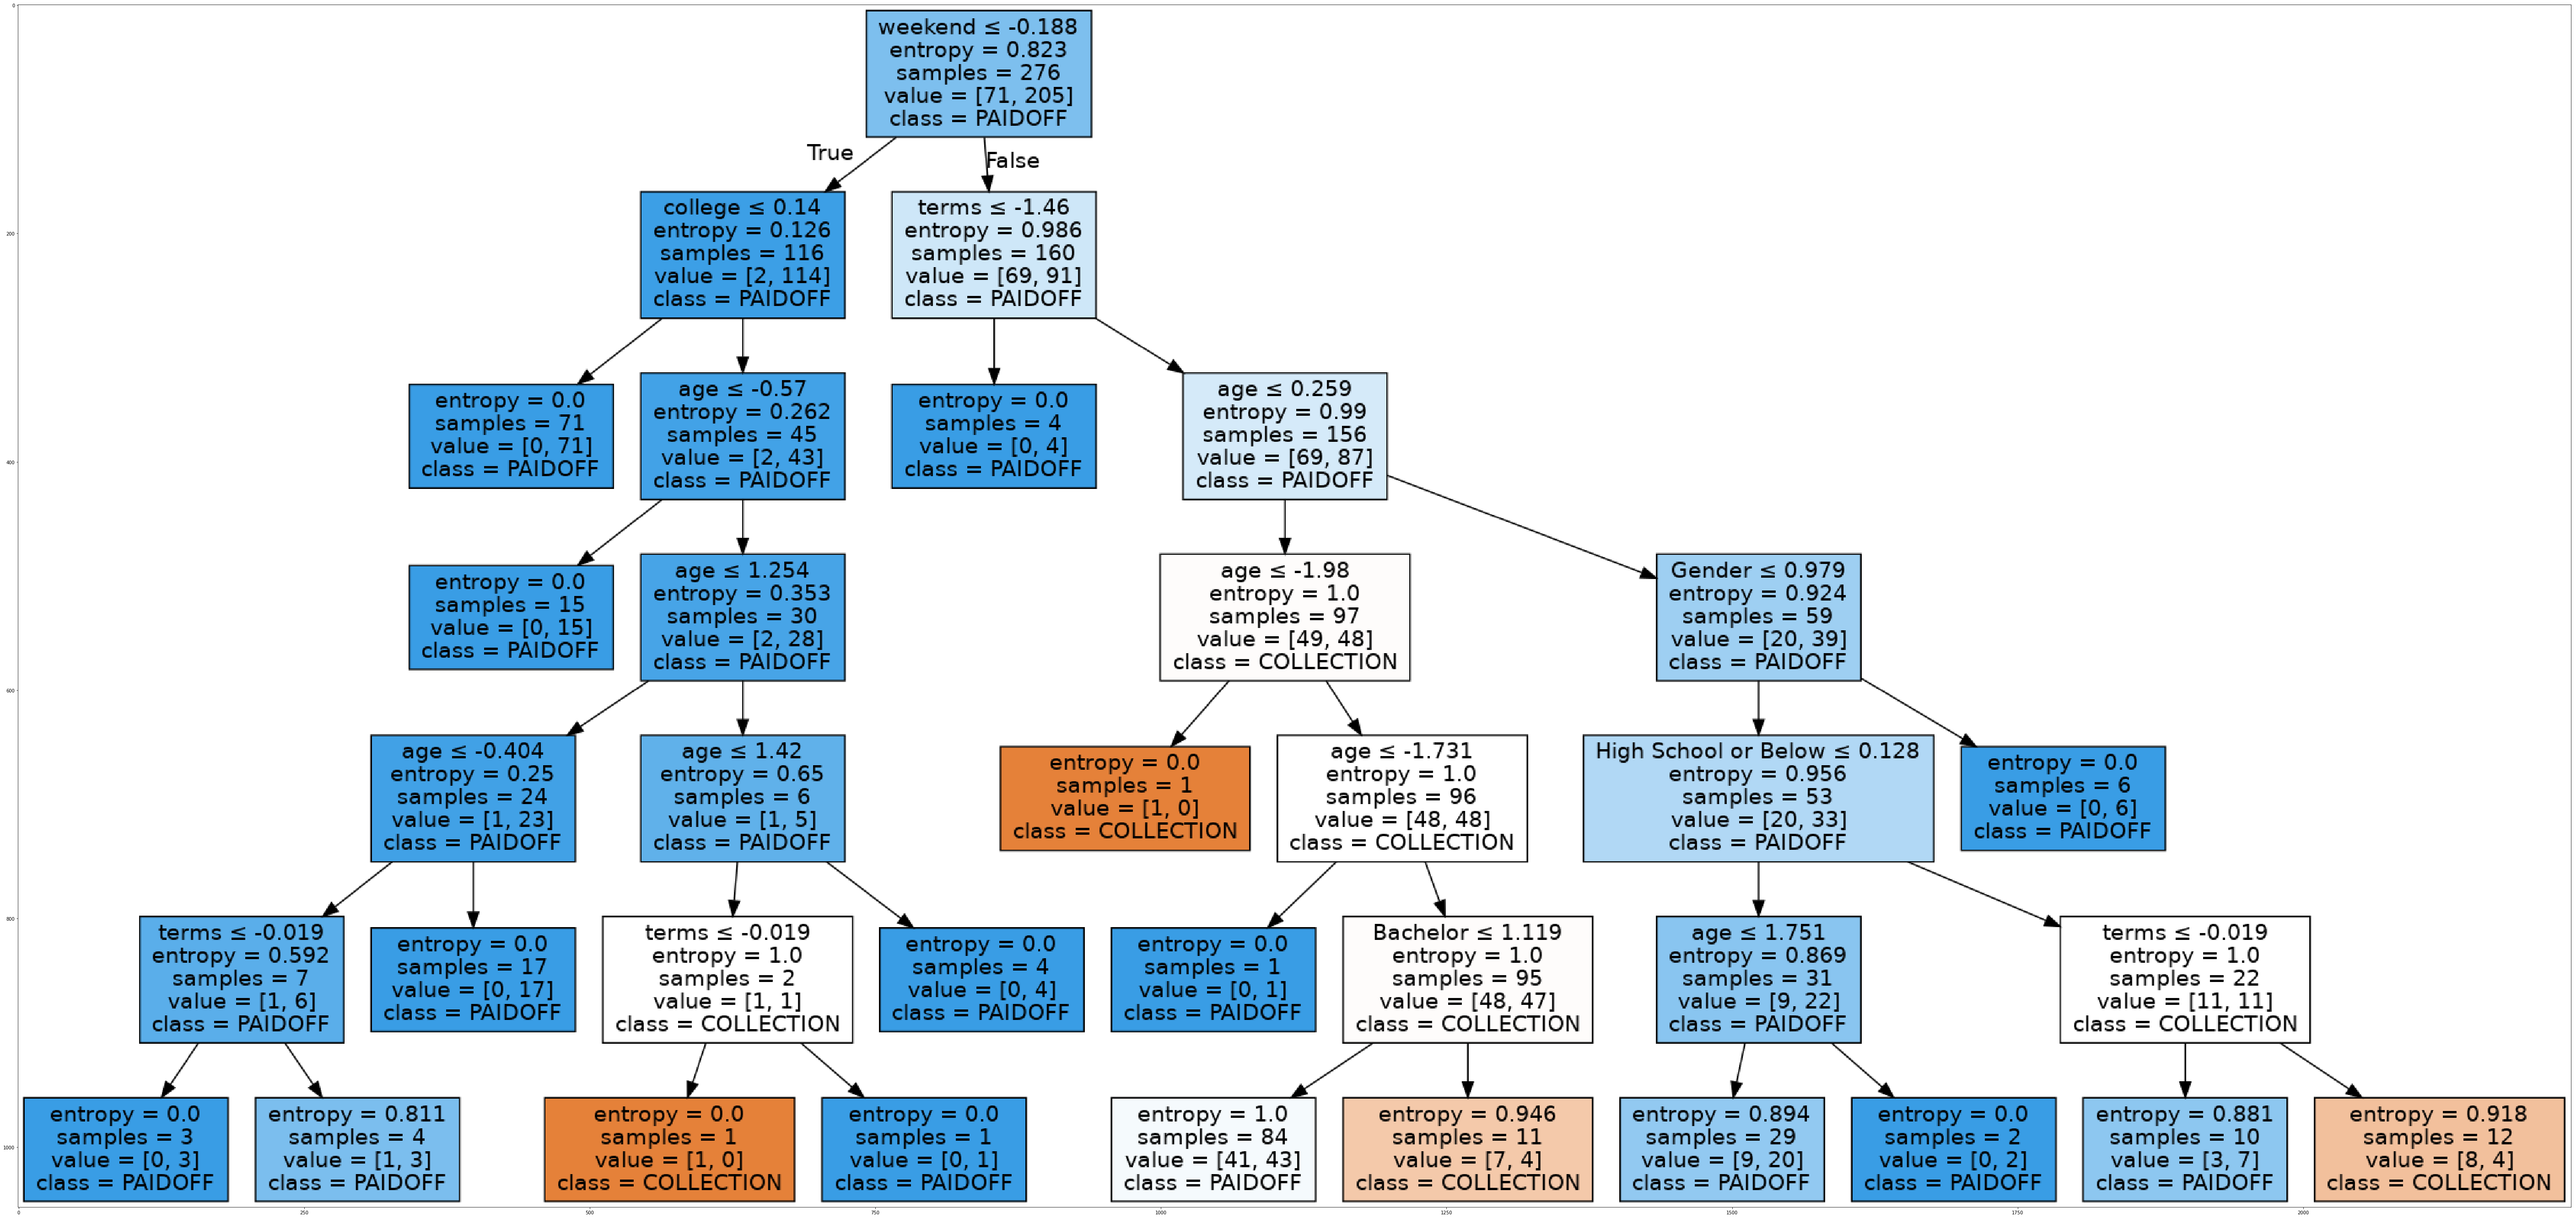

In [61]:
Tree6 = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
Tree6.fit(X_train, y_train)

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

predTree6 = Tree6.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree6))

dot_data = StringIO()
filename = "Tree6.png"
featureNames = ['Principal','terms','age','Gender','weekend','Bachelor','High School or Below','college']
targetNames = [0,1]
out=tree.export_graphviz(Tree6 ,feature_names=featureNames, out_file=dot_data, class_names= np.array(['COLLECTION','PAIDOFF']), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

Conclusion = Decision tree is really bad at this.  The most acurrate max_depths are 1, 2, and 6.  Except that depths 1 and 2 conclude that every loan is "PAIDOFF"  Meaning this algorith is not able to find good split parameters for this dataset.  Even though max_depth = 1 or 2 is more accurate I am going to go with max_depth = 6 due to it actually including situations where class = COLLECTION

In [63]:
final__tree = Tree6

# Support Vector Machine

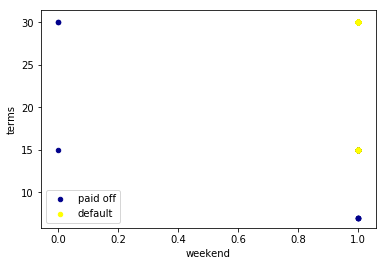

In [66]:
ax = df[df['loan_status'] == 1][0:50].plot(kind='scatter', x='weekend', y='terms', color='DarkBlue', label='paid off');
df[df['loan_status'] == 0][0:50].plot(kind='scatter', x='weekend', y='terms', color='Yellow', label='default', ax=ax);
plt.show()

As seen in the decision tree, it is difficult to find a way to seperate the data to make evaluation possible.  Let's go ahead and train the model using Radial Basis Function.  We can try others later.

In [67]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train) 

svm_yhat = svm_model.predict(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Let's evaluate the accuracy

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svm_yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, svm_yhat))

print(cnf_matrix)

              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

[[ 4 11]
 [ 7 48]]


As seen before, the algorithm has a very hard time correctly evaluating something as 0. It tends to evaluate everything as 1 ('PaidOFF') instaed.  Let's try Linear instead and see if it is more accurate.

In [72]:
svm_model_linear = svm.SVC(kernel='linear')
svm_model_linear.fit(X_train, y_train) 

svm_yhat_lineaer = svm_model_linear.predict(X_test)

# Compute confusion matrix
cnf_matrix_linear = confusion_matrix(y_test, svm_yhat_lineaer, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, svm_yhat_lineaer))

print(cnf_matrix_linear)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

[[ 0 15]
 [ 0 55]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It turns out our linear algorithm is even worse and identified every value as "PAIDOFF".  This dataset does not seem to have any good features to truly determine "PAIDOFF" vs "COLLECTION"  We are going to keep the first model using 'rbf'

In [73]:
final_SVM = svm_model

# Logistic Regression

The first time I ran this with Cs = [0.001, 0.01, 0.1] and found that 0.1 was the most accurate so we will try with addition values

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score

Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]
for c in Cs:
    LR = LogisticRegression(C = c, solver='liblinear').fit(X_train,y_train)
    yhat_lr = LR.predict(X_test)
    print(f'Jaccard score for linear where C = {c}: {jaccard_similarity_score(y_test, yhat_lr)}')

Jaccard score for linear where C = 0.001: 0.6714285714285714
Jaccard score for linear where C = 0.005: 0.6857142857142857
Jaccard score for linear where C = 0.01: 0.6857142857142857
Jaccard score for linear where C = 0.05: 0.7428571428571429
Jaccard score for linear where C = 0.1: 0.7428571428571429
Jaccard score for linear where C = 0.15: 0.7428571428571429
Jaccard score for linear where C = 0.2: 0.7285714285714285
Jaccard score for linear where C = 0.3: 0.7285714285714285
Jaccard score for linear where C = 0.4: 0.7285714285714285


It appears that C = 0.1 is the most accurate.  Again, I am concerned due to the fact that the accuracy percentage seems to match the ratio of PAIDOFF to COLLECTION<br>
Let's try some additional solvers such as 'newton-cg' and 'lbfgs'

In [85]:
for c in Cs:
    LR_newton = LogisticRegression(C = c, solver='newton-cg').fit(X_train,y_train)
    yhat_lr_newton = LR_newton.predict(X_test)
    print(f'Jaccard score newton-cg where for C = {c}: {jaccard_similarity_score(y_test, yhat_lr_newton)}')

Jaccard score newton-cg where for C = 0.001: 0.7857142857142857
Jaccard score newton-cg where for C = 0.005: 0.7857142857142857
Jaccard score newton-cg where for C = 0.01: 0.7857142857142857
Jaccard score newton-cg where for C = 0.05: 0.7857142857142857
Jaccard score newton-cg where for C = 0.1: 0.7714285714285715
Jaccard score newton-cg where for C = 0.15: 0.7571428571428571
Jaccard score newton-cg where for C = 0.2: 0.7571428571428571
Jaccard score newton-cg where for C = 0.3: 0.7428571428571429
Jaccard score newton-cg where for C = 0.4: 0.7428571428571429


In [86]:
for c in Cs:
    LR_lbfgs = LogisticRegression(C = c, solver='lbfgs').fit(X_train,y_train)
    yhat_lr_lbfgs = LR_lbfgs.predict(X_test)
    print(f'Jaccard score for lbfgss where C = {c}: {jaccard_similarity_score(y_test, yhat_lr_lbfgs)}')

Jaccard score for lbfgss where C = 0.001: 0.7857142857142857
Jaccard score for lbfgss where C = 0.005: 0.7857142857142857
Jaccard score for lbfgss where C = 0.01: 0.7857142857142857
Jaccard score for lbfgss where C = 0.05: 0.7857142857142857
Jaccard score for lbfgss where C = 0.1: 0.7714285714285715
Jaccard score for lbfgss where C = 0.15: 0.7571428571428571
Jaccard score for lbfgss where C = 0.2: 0.7571428571428571
Jaccard score for lbfgss where C = 0.3: 0.7428571428571429
Jaccard score for lbfgss where C = 0.4: 0.7428571428571429


In [87]:
for c in Cs:
    LR_sag = LogisticRegression(C = c, solver='sag').fit(X_train,y_train)
    yhat_lr_sag = LR_sag.predict(X_test)
    print(f'Jaccard score for sag where C = {c}: {jaccard_similarity_score(y_test, yhat_lr_sag)}')

Jaccard score for sag where C = 0.001: 0.7857142857142857
Jaccard score for sag where C = 0.005: 0.7857142857142857
Jaccard score for sag where C = 0.01: 0.7857142857142857
Jaccard score for sag where C = 0.05: 0.7857142857142857
Jaccard score for sag where C = 0.1: 0.7714285714285715
Jaccard score for sag where C = 0.15: 0.7571428571428571
Jaccard score for sag where C = 0.2: 0.7571428571428571
Jaccard score for sag where C = 0.3: 0.7428571428571429
Jaccard score for sag where C = 0.4: 0.7428571428571429


In [88]:
for c in Cs:
    LR_saga = LogisticRegression(C = c, solver='saga').fit(X_train,y_train)
    yhat_lr_saga = LR_saga.predict(X_test)
    print(f'Jaccard score for saga where C = {c}: {jaccard_similarity_score(y_test, yhat_lr_saga)}')

Jaccard score for saga where C = 0.001: 0.7857142857142857
Jaccard score for saga where C = 0.005: 0.7857142857142857
Jaccard score for saga where C = 0.01: 0.7857142857142857
Jaccard score for saga where C = 0.05: 0.7857142857142857
Jaccard score for saga where C = 0.1: 0.7714285714285715
Jaccard score for saga where C = 0.15: 0.7571428571428571
Jaccard score for saga where C = 0.2: 0.7571428571428571
Jaccard score for saga where C = 0.3: 0.7428571428571429
Jaccard score for saga where C = 0.4: 0.7428571428571429


Everthing but linear gave us the same max Jaccard score, we will use newton-cg with C = 0.01

In [89]:
final_LR = LR = LogisticRegression(C = 0.01, solver='newton-cg').fit(X_train,y_train)

# Model Evaluation using Test set

In [112]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [90]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-24 00:56:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-24 00:57:00 (195 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [109]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


First, we need to preprocess the data.

In [110]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]


Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_X = Feature
# confirm the format of our data
print(test_X[0:5])

test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)



test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1],inplace=True)
test_y = test_df['loan_status'].values



   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college  
0        0  
1        0  
2        0  
3        1  
4        0  


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [117]:
yhat_neigh = final_neigh.predict(test_X)
yhat_tree = final__tree.predict(test_X)
yhat_SVM = final_SVM.predict(test_X)
yhat_LR = final_LR.predict(test_X)
yhat_LR_prob = final_LR.predict_proba(test_X)

results = []
results.append(['KNN',jaccard_similarity_score(test_y, yhat_neigh), f1_score(test_y, yhat_neigh), 'NA'])
results.append(['Decision Tree',jaccard_similarity_score(test_y, yhat_tree), f1_score(test_y, yhat_tree), 'NA'])
results.append(['SVM',jaccard_similarity_score(test_y, yhat_SVM), f1_score(test_y, yhat_SVM), 'NA'])
results.append(['Logistic Regression',jaccard_similarity_score(test_y, yhat_LR), f1_score(test_y, yhat_LR), log_loss(test_y, yhat_LR_prob)])

Turn results in Panda for better viewing.

In [118]:
from pandas import DataFrame
results_df = DataFrame(results,columns=['Algorithm', 'Jaccard', 'F1-score','Log Loss'])

In [119]:
results_df

,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.790698,NA
1,Decision Tree,0.722222,0.831461,NA
2,SVM,0.796296,0.876404,NA
3,Logistic Regression,0.740741,0.851064,0.516366


Conclusion: SVM using 'rbf' is the most accurate model to predict this sample dataset.

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>